In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import lightgbm as lgb
# import matplotlib.pyplot as plt
import gc

# Carregando base

In [2]:
df = pd.read_parquet('base/base_desenvolvimento.parquet.gzip')

# Seleção de features

In [29]:
features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'CDL_DOJI_10_0.1', 'CDL_INSIDE', 'open_Z_30_1', 'AO_5_34',
    'APO_12_26', 'BIAS_SMA_26', 'BOP', 'AR_26', 'BR_26', 'CCI_14_0.015', 'CFO_9', 'CG_10', 'CMO_14', 'COPC_11_14_10',
    'CTI_12', 'ER_10', 'BULLP_13', 'BEARP_13', 'FISHERT_9_1', 'INERTIA_20_14', 'K_9_3', 'D_9_3', 'J_9_3', 'KST_10_15_20_30_10_10_10_15',
    'MACDh_12_26_9', 'MOM_10', 'PGO_14', 'PPO_12_26_9', 'PPOh_12_26_9', 'PSL_12', 'PVO_12_26_9', 'PVOh_12_26_9', 'PVOs_12_26_9',
    'QQE_14_5_4.236', 'ROC_10', 'RSX_14', 'RVGI_14_4', 'SLOPE_1', 'SMIo_5_20_5', 'SQZ_20_2.0_20_1.5', 'SQZ_ON', 'SQZ_NO',
    'SQZPRO_ON_WIDE', 'SQZPRO_ON_NARROW', 'SQZPRO_NO', 'STC_10_12_26_0.5', 'STCstoch_10_12_26_0.5', 'STOCHRSIk_14_14_3_3',
    'STOCHRSId_14_14_3_3', 'TRIX_30_9', 'TSIs_13_25_13', 'UO_7_14_28', 'WILLR_14', 'LOGRET_1', 'ENTP_10', 'KURT_30', 'MAD_30',
    'SKEW_30', 'TOS_STDEVALL_L_1', 'TOS_STDEVALL_L_2', 'TOS_STDEVALL_L_3', 'VAR_30', 'ADX_14', 'DMP_14', 'DMN_14', 'AMATe_LR_8_21_2',
    'AROOND_14', 'AROONU_14', 'AROONOSC_14', 'CHOP_14_1_100', 'DEC_1', 'DPO_20', 'INC_1', 'PSARaf_0.02_0.2', 'PSARr_0.02_0.2',
    'QS_10', 'TTM_TRND_6', 'VHF_28', 'VTXP_14', 'VTXM_14', 'ABER_ATR_5_15', 'BBB_5_2.0', 'BBP_5_2.0', 'MASSI_9_25', 'NATR_14',
    'PDIST', 'RVI_14', 'THERMO_20_2_0.5', 'THERMOl_20_2_0.5', 'THERMOs_20_2_0.5', 'UI_14', 'AD', 'ADOSC_3_10', 'OBV',
    'AOBV_LR_2', 'CMF_20', 'EFI_13', 'KVO_34_55_13', 'KVOs_34_55_13', 'MFI_14', 'NVI_1', 'PVI_1', 'PVOL', 'PVR',
    'PVT', 'mes', 'dia_semana', 'dia_mes', 'dia_ano']

In [30]:
df.dropna(subset=features+['label_l1'], inplace=True)
model = lgb.LGBMClassifier(importance_type='gain')
model.fit(df[features], df['label_l1'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23130
[LightGBM] [Info] Number of data points in the train set: 140841, number of used features: 112
[LightGBM] [Info] Start training from score -0.140770
[LightGBM] [Info] Start training from score -2.724956
[LightGBM] [Info] Start training from score -2.721712


LGBMClassifier(importance_type='gain')

Selecionando features com maior importancia para lgbm

<Axes: >

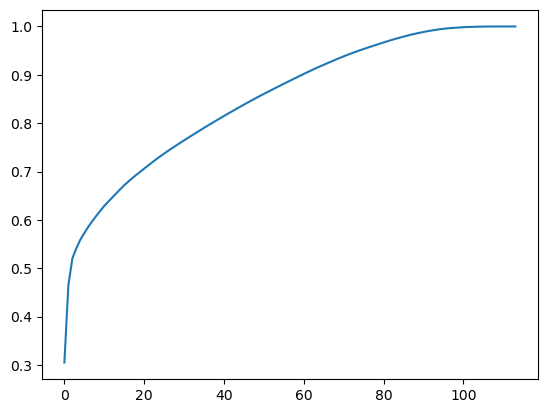

In [31]:
def get_importance(model):
    df_importance = pd.DataFrame({'feature': model.feature_name_,
                                 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
    df_importance['frac'] = df_importance['importance'] / \
        df_importance['importance'].sum()
    df_importance['frac'] = df_importance['frac'].cumsum(
    )
    return df_importance


df_importance = get_importance(model).reset_index(drop=True)
df_importance['frac'].plot()

In [32]:
df_importance.head()

,feature,importance,frac
0,BBP_5_2.0,55450.274768,0.305217
1,DPO_20,29056.889455,0.465155
2,BBB_5_2.0,10059.051055,0.520524
3,dia_ano,3798.412226,0.541432
4,dia_mes,3225.520266,0.559186


In [33]:
df_importance[df_importance['frac'] <= .90].shape

(60, 3)

In [34]:
df_importance.iloc[59]

feature         WILLR_14
importance    733.526008
frac            0.897841
Name: 59, dtype: object

60 features são responsáveis por 90% da importância. Teste para 60 features

In [35]:
# selecionando as princi
features = df_importance.iloc[:60]['feature'].to_list()

In [36]:
features

['BBP_5_2.0',
 'DPO_20',
 'BBB_5_2.0',
 'dia_ano',
 'dia_mes',
 'NATR_14',
 'CCI_14_0.015',
 'LOGRET_1',
 'J_9_3',
 'THERMO_20_2_0.5',
 'dia_semana',
 'SMIo_5_20_5',
 'CFO_9',
 'SLOPE_1',
 'PGO_14',
 'BEARP_13',
 'BOP',
 'PDIST',
 'BULLP_13',
 'PVOh_12_26_9',
 'ABER_ATR_5_15',
 'PPOh_12_26_9',
 'MFI_14',
 'PVOL',
 'Volume',
 'DMN_14',
 'CG_10',
 'PVOs_12_26_9',
 'CHOP_14_1_100',
 'VHF_28',
 'RVI_14',
 'MOM_10',
 'TRIX_30_9',
 'KURT_30',
 'QS_10',
 'MASSI_9_25',
 'PVI_1',
 'UI_14',
 'UO_7_14_28',
 'DMP_14',
 'STOCHRSIk_14_14_3_3',
 'PVO_12_26_9',
 'BR_26',
 'AR_26',
 'ER_10',
 'CMF_20',
 'ROC_10',
 'MACDh_12_26_9',
 'TOS_STDEVALL_L_3',
 'SKEW_30',
 'K_9_3',
 'STOCHRSId_14_14_3_3',
 'VTXM_14',
 'CTI_12',
 'TOS_STDEVALL_L_2',
 'INERTIA_20_14',
 'ADX_14',
 'TSIs_13_25_13',
 'VTXP_14',
 'WILLR_14']

In [37]:
len(features)

60

# base

In [38]:
df.dropna(subset=features+['label_l1'], inplace=True)

In [39]:
df.shape

(140841, 121)

### padronizando  valores

In [40]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

### separando em base treino e teste

In [41]:
df_train = df.loc[(df['Date'] >= '2018-06-01') &
                  (df['Date'] <= '2023-12-31')]
df_test = df.loc[(df['Date'] > '2023-12-31')]

In [42]:
df_train.shape, df_test.shape

((89960, 121), (7150, 121))

In [43]:
# separando X , y , considerando 28 dias (1 dia por parametro image 28 x 28)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Estruturando base


In [44]:
df_test['label_l1'].dropna(inplace=True)
df_train['label_l1'].dropna(inplace=True)

In [46]:
window = 60
n_features = len(features)
n_features

60

In [47]:
df_train.shape[0]-60

89900

In [48]:
acoes = df_train['acao'].unique()

In [49]:
acoes

['ABCB4', 'ALUP11', 'ARZZ3', 'B3SA3', 'BBAS3', ..., 'UNIP6', 'USIM5', 'VALE3', 'VIVT3', 'WEGE3']
Length: 65
Categories (65, object): ['ABCB4', 'ALUP11', 'ARZZ3', 'B3SA3', ..., 'USIM5', 'VALE3', 'VIVT3', 'WEGE3']

In [50]:
X_train = np.zeros((89900, 60, 60))
X_train.shape

(89900, 60, 60)

In [51]:
from tqdm import tqdm

# separa Xconsiderando window dias x parametros  (Ex: para window 28 dias e 28 parametros  imagem 28 x 28)

window = 60
n_features = len(features)
X_train = []
Y_train = []
for acao in acoes:
    print(f'iniciando {acao}')
    df_aux = df_train[df_train['acao'] == acao]
    registros = df_aux.shape[0]-window
    array_result = np.zeros((registros, window, n_features))

    idx = 0
    idy = window
    for i in tqdm(range(window, df_aux.shape[0])):

        array_result[idx] = df_aux[features].iloc[idx:i].values

        y_train = df_aux['label_l1'].iloc[i-1]

        Y_train.append(y_train)

        idx += 1

    X_train.append(array_result)

iniciando ABCB4


100%|██████████| 1324/1324 [00:00<00:00, 2666.14it/s]


iniciando ALUP11


100%|██████████| 1324/1324 [00:00<00:00, 2748.82it/s]


iniciando ARZZ3


100%|██████████| 1324/1324 [00:00<00:00, 2734.98it/s]


iniciando B3SA3


100%|██████████| 1324/1324 [00:00<00:00, 2749.39it/s]


iniciando BBAS3


100%|██████████| 1324/1324 [00:00<00:00, 2759.06it/s]


iniciando BBSE3


100%|██████████| 1324/1324 [00:00<00:00, 2754.40it/s]


iniciando BPAN4


100%|██████████| 1324/1324 [00:00<00:00, 2775.47it/s]


iniciando BRAP4


100%|██████████| 1324/1324 [00:00<00:00, 2718.40it/s]


iniciando CMIG3


100%|██████████| 1324/1324 [00:00<00:00, 2752.23it/s]


iniciando CMIG4


100%|██████████| 1324/1324 [00:00<00:00, 2769.88it/s]


iniciando CPFE3


100%|██████████| 1324/1324 [00:00<00:00, 2768.91it/s]


iniciando CPLE3


100%|██████████| 1324/1324 [00:00<00:00, 2772.77it/s]


iniciando CPLE6


100%|██████████| 1324/1324 [00:00<00:00, 2775.50it/s]


iniciando CSAN3


100%|██████████| 1324/1324 [00:00<00:00, 2783.00it/s]


iniciando CSMG3


100%|██████████| 1324/1324 [00:00<00:00, 2561.51it/s]


iniciando CSNA3


100%|██████████| 1324/1324 [00:00<00:00, 2781.38it/s]


iniciando CYRE3


100%|██████████| 1324/1324 [00:00<00:00, 2777.07it/s]


iniciando EGIE3


100%|██████████| 1324/1324 [00:00<00:00, 2758.10it/s]


iniciando ELET3


100%|██████████| 1324/1324 [00:00<00:00, 2747.06it/s]


iniciando ELET6


100%|██████████| 1324/1324 [00:00<00:00, 2763.30it/s]


iniciando ENAT3


100%|██████████| 1324/1324 [00:00<00:00, 2770.78it/s]


iniciando ENEV3


100%|██████████| 1324/1324 [00:00<00:00, 2775.04it/s]


iniciando ENGI11


100%|██████████| 1324/1324 [00:00<00:00, 2782.47it/s]


iniciando EQTL3


100%|██████████| 1324/1324 [00:00<00:00, 2769.88it/s]


iniciando FRAS3


100%|██████████| 1324/1324 [00:00<00:00, 2754.73it/s]


iniciando GGBR4


100%|██████████| 1324/1324 [00:00<00:00, 2771.85it/s]


iniciando GOAU4


100%|██████████| 1324/1324 [00:00<00:00, 2771.91it/s]


iniciando GRND3


100%|██████████| 1324/1324 [00:00<00:00, 2769.89it/s]


iniciando HYPE3


100%|██████████| 1324/1324 [00:00<00:00, 2772.74it/s]


iniciando ITSA4


100%|██████████| 1324/1324 [00:00<00:00, 2768.08it/s]


iniciando ITUB3


100%|██████████| 1324/1324 [00:00<00:00, 2724.33it/s]


iniciando ITUB4


100%|██████████| 1324/1324 [00:00<00:00, 2763.98it/s]


iniciando JBSS3


100%|██████████| 1324/1324 [00:00<00:00, 2769.70it/s]


iniciando JHSF3


100%|██████████| 1324/1324 [00:00<00:00, 2757.04it/s]


iniciando KLBN11


100%|██████████| 1324/1324 [00:00<00:00, 2560.94it/s]


iniciando KLBN4


100%|██████████| 1324/1324 [00:00<00:00, 2765.53it/s]


iniciando LEVE3


100%|██████████| 1324/1324 [00:00<00:00, 2752.59it/s]


iniciando MRFG3


100%|██████████| 1324/1324 [00:00<00:00, 2763.92it/s]


iniciando MULT3


100%|██████████| 1324/1324 [00:00<00:00, 2755.99it/s]


iniciando PETR3


100%|██████████| 1324/1324 [00:00<00:00, 2775.43it/s]


iniciando PETR4


100%|██████████| 1324/1324 [00:00<00:00, 2746.86it/s]


iniciando POMO3


100%|██████████| 1324/1324 [00:00<00:00, 2769.06it/s]


iniciando POMO4


100%|██████████| 1324/1324 [00:00<00:00, 2764.93it/s]


iniciando PRIO3


100%|██████████| 1324/1324 [00:00<00:00, 2769.65it/s]


iniciando PSSA3


100%|██████████| 1324/1324 [00:00<00:00, 2776.19it/s]


iniciando RADL3


100%|██████████| 1324/1324 [00:00<00:00, 2781.82it/s]


iniciando RAIL3


100%|██████████| 1324/1324 [00:00<00:00, 2775.51it/s]


iniciando RAPT4


100%|██████████| 1324/1324 [00:00<00:00, 2774.49it/s]


iniciando RENT3


100%|██████████| 1324/1324 [00:00<00:00, 2769.85it/s]


iniciando SANB11


100%|██████████| 1324/1324 [00:00<00:00, 2769.09it/s]


iniciando SAPR4


100%|██████████| 1324/1324 [00:00<00:00, 2769.70it/s]


iniciando SBSP3


100%|██████████| 1324/1324 [00:00<00:00, 2575.17it/s]


iniciando SMTO3


100%|██████████| 1324/1324 [00:00<00:00, 2741.20it/s]


iniciando STBP3


100%|██████████| 1324/1324 [00:00<00:00, 2732.79it/s]


iniciando SUZB3


100%|██████████| 1324/1324 [00:00<00:00, 2752.46it/s]


iniciando TAEE11


100%|██████████| 1324/1324 [00:00<00:00, 2667.92it/s]


iniciando TIMS3


100%|██████████| 1324/1324 [00:00<00:00, 2674.96it/s]


iniciando TOTS3


100%|██████████| 1324/1324 [00:00<00:00, 2742.38it/s]


iniciando TRPL4


100%|██████████| 1324/1324 [00:00<00:00, 2734.26it/s]


iniciando TUPY3


100%|██████████| 1324/1324 [00:00<00:00, 2747.51it/s]


iniciando UNIP6


100%|██████████| 1324/1324 [00:00<00:00, 2707.16it/s]


iniciando USIM5


100%|██████████| 1324/1324 [00:00<00:00, 2768.75it/s]


iniciando VALE3


100%|██████████| 1324/1324 [00:00<00:00, 2769.47it/s]


iniciando VIVT3


100%|██████████| 1324/1324 [00:00<00:00, 2757.80it/s]


iniciando WEGE3


100%|██████████| 1324/1324 [00:00<00:00, 2745.66it/s]


In [52]:
np.array(X_train).shape

(65, 1324, 60, 60)

In [53]:
X = X_train[0]
for i, k in enumerate(X_train[1:]):
    X = np.concatenate([X, k])

In [54]:
X.shape

(86060, 60, 60)

In [61]:
Y_train = np.array(Y_train)
Y_train.shape

(86060,)

# balanceando

In [62]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np

In [63]:
X.shape

(86060, 60, 60)

In [60]:
X_reshape = X.reshape(86060, 60*60)

In [64]:
X_reshape.shape

(86060, 3600)

In [65]:
sm = RandomOverSampler(random_state=42)
x_over, y_over = sm.fit_resample(X_reshape, Y_train)

In [66]:
x_over.shape

(225120, 3600)

In [67]:
x_over = x_over.reshape(225120, 60, 60)

In [68]:
x_over.shape

(225120, 60, 60)

In [69]:
# salvando
np.save('base/X_train_balance_torch_2.npy', x_over)
np.save('base/y_train_balance_torch_2.npy', y_over)

# base teste

In [70]:
from tqdm import tqdm

# separa Xconsiderando window dias x parametros  (Ex: para window 28 dias e 28 parametros  imagem 28 x 28)

window = 60
n_features = len(features)
X_test = []
Y_test = []

Data = []
Acao = []
Close = []

for acao in acoes:
    print(f'iniciando {acao}')
    df_aux = df_test[df_test['acao'] == acao]
    registros = df_aux.shape[0]-window
    array_result = np.zeros((registros, window, n_features))

    idx = 0
    idy = 60
    for i in tqdm(range(window, df_aux.shape[0])):

        array_result[idx] = df_aux[features].iloc[idx:i].values

        y_test = df_aux['label_l1'].iloc[i-1]
        data = df_aux['Date'].iloc[i-1]
        acao = df_aux['acao'].iloc[i-1]
        close = df_aux['Close'].iloc[i-1]

        Y_test.append(y_test)
        Data.append(data)
        Acao.append(acao)
        Close.append(close)

        idx += 1

    X_test.append(array_result)

iniciando ABCB4


100%|██████████| 50/50 [00:00<00:00, 2243.04it/s]


iniciando ALUP11


100%|██████████| 50/50 [00:00<00:00, 2318.68it/s]


iniciando ARZZ3


100%|██████████| 50/50 [00:00<00:00, 2263.08it/s]


iniciando B3SA3


100%|██████████| 50/50 [00:00<00:00, 2266.82it/s]


iniciando BBAS3


100%|██████████| 50/50 [00:00<00:00, 2149.87it/s]


iniciando BBSE3


100%|██████████| 50/50 [00:00<00:00, 2293.47it/s]


iniciando BPAN4


100%|██████████| 50/50 [00:00<00:00, 2364.29it/s]


iniciando BRAP4


100%|██████████| 50/50 [00:00<00:00, 2384.05it/s]


iniciando CMIG3


100%|██████████| 50/50 [00:00<00:00, 2261.54it/s]


iniciando CMIG4


100%|██████████| 50/50 [00:00<00:00, 2352.41it/s]


iniciando CPFE3


100%|██████████| 50/50 [00:00<00:00, 2257.48it/s]


iniciando CPLE3


100%|██████████| 50/50 [00:00<00:00, 2262.79it/s]


iniciando CPLE6


100%|██████████| 50/50 [00:00<00:00, 2263.81it/s]


iniciando CSAN3


100%|██████████| 50/50 [00:00<00:00, 2425.18it/s]


iniciando CSMG3


100%|██████████| 50/50 [00:00<00:00, 2431.90it/s]


iniciando CSNA3


100%|██████████| 50/50 [00:00<00:00, 1749.30it/s]


iniciando CYRE3


100%|██████████| 50/50 [00:00<00:00, 1917.05it/s]


iniciando EGIE3


100%|██████████| 50/50 [00:00<00:00, 1666.87it/s]


iniciando ELET3


100%|██████████| 50/50 [00:00<00:00, 2171.41it/s]


iniciando ELET6


100%|██████████| 50/50 [00:00<00:00, 2218.93it/s]


iniciando ENAT3


100%|██████████| 50/50 [00:00<00:00, 1662.02it/s]


iniciando ENEV3


100%|██████████| 50/50 [00:00<00:00, 2122.34it/s]


iniciando ENGI11


100%|██████████| 50/50 [00:00<00:00, 2497.89it/s]


iniciando EQTL3


100%|██████████| 50/50 [00:00<00:00, 2378.37it/s]


iniciando FRAS3


100%|██████████| 50/50 [00:00<00:00, 2413.38it/s]


iniciando GGBR4


100%|██████████| 50/50 [00:00<00:00, 2209.41it/s]


iniciando GOAU4


100%|██████████| 50/50 [00:00<00:00, 2212.84it/s]


iniciando GRND3


100%|██████████| 50/50 [00:00<00:00, 2373.93it/s]


iniciando HYPE3


100%|██████████| 50/50 [00:00<00:00, 2258.40it/s]


iniciando ITSA4


100%|██████████| 50/50 [00:00<00:00, 2263.74it/s]


iniciando ITUB3


100%|██████████| 50/50 [00:00<00:00, 2353.20it/s]


iniciando ITUB4


100%|██████████| 50/50 [00:00<00:00, 2421.96it/s]


iniciando JBSS3


100%|██████████| 50/50 [00:00<00:00, 2129.00it/s]


iniciando JHSF3


100%|██████████| 50/50 [00:00<00:00, 2172.18it/s]


iniciando KLBN11


100%|██████████| 50/50 [00:00<00:00, 2150.88it/s]


iniciando KLBN4


100%|██████████| 50/50 [00:00<00:00, 2372.02it/s]


iniciando LEVE3


100%|██████████| 50/50 [00:00<00:00, 2215.08it/s]


iniciando MRFG3


100%|██████████| 50/50 [00:00<00:00, 2038.58it/s]


iniciando MULT3


100%|██████████| 50/50 [00:00<00:00, 2324.64it/s]


iniciando PETR3


100%|██████████| 50/50 [00:00<00:00, 2377.59it/s]


iniciando PETR4


100%|██████████| 50/50 [00:00<00:00, 2226.87it/s]


iniciando POMO3


100%|██████████| 50/50 [00:00<00:00, 2219.00it/s]


iniciando POMO4


100%|██████████| 50/50 [00:00<00:00, 2372.93it/s]


iniciando PRIO3


100%|██████████| 50/50 [00:00<00:00, 2318.86it/s]


iniciando PSSA3


100%|██████████| 50/50 [00:00<00:00, 2216.00it/s]


iniciando RADL3


100%|██████████| 50/50 [00:00<00:00, 2149.25it/s]


iniciando RAIL3


100%|██████████| 50/50 [00:00<00:00, 2374.06it/s]


iniciando RAPT4


100%|██████████| 50/50 [00:00<00:00, 2181.19it/s]


iniciando RENT3


100%|██████████| 50/50 [00:00<00:00, 2226.65it/s]


iniciando SANB11


100%|██████████| 50/50 [00:00<00:00, 2378.56it/s]


iniciando SAPR4


100%|██████████| 50/50 [00:00<00:00, 2269.23it/s]


iniciando SBSP3


100%|██████████| 50/50 [00:00<00:00, 2376.86it/s]


iniciando SMTO3


100%|██████████| 50/50 [00:00<00:00, 2311.57it/s]


iniciando STBP3


100%|██████████| 50/50 [00:00<00:00, 2369.26it/s]


iniciando SUZB3


100%|██████████| 50/50 [00:00<00:00, 2326.99it/s]


iniciando TAEE11


100%|██████████| 50/50 [00:00<00:00, 2489.47it/s]


iniciando TIMS3


100%|██████████| 50/50 [00:00<00:00, 2393.63it/s]


iniciando TOTS3


100%|██████████| 50/50 [00:00<00:00, 2380.91it/s]


iniciando TRPL4


100%|██████████| 50/50 [00:00<00:00, 2275.01it/s]


iniciando TUPY3


100%|██████████| 50/50 [00:00<00:00, 2371.06it/s]


iniciando UNIP6


100%|██████████| 50/50 [00:00<00:00, 2364.93it/s]


iniciando USIM5


100%|██████████| 50/50 [00:00<00:00, 1993.96it/s]


iniciando VALE3


100%|██████████| 50/50 [00:00<00:00, 2319.27it/s]


iniciando VIVT3


100%|██████████| 50/50 [00:00<00:00, 2377.08it/s]


iniciando WEGE3


100%|██████████| 50/50 [00:00<00:00, 2312.82it/s]


In [71]:
df_test = pd.DataFrame(
    {'Date': Data, 'acao': Acao, 'Close': Close, 'label_l1': Y_test})

In [72]:
df_test[['acao', 'Date', 'Close', 'label_l1']]

,acao,Date,Close,label_l1
0,ABCB4,2024-03-27,24.094305,0.0
1,ABCB4,2024-03-28,23.370895,2.0
2,ABCB4,2024-04-01,24.518703,0.0
3,ABCB4,2024-04-02,24.190760,0.0
4,ABCB4,2024-04-03,23.698841,0.0
...,...,...,...,...
3245,WEGE3,2024-06-03,37.284451,0.0
3246,WEGE3,2024-06-04,37.743767,0.0
3247,WEGE3,2024-06-05,37.484154,0.0
3248,WEGE3,2024-06-06,37.753754,0.0


In [73]:
X = X_test[0]
for i, k in enumerate(X_test[1:]):
    X = np.concatenate([X, k])

In [74]:
X.shape

(3250, 60, 60)

In [75]:
df_test.shape

(3250, 4)

In [76]:
# teste save

np.save('base/X_test_torch_2.npy', X)
np.save('base/y_test_torch_2.npy', np.array(Y_test))

In [77]:
df_test.to_csv('base/y_test_2.csv', index=False)

In [78]:
np.array(Y_test).shape

(3250,)